# Random forest classifier from scratch

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import operator
%matplotlib inline
from scipy.stats import itemfreq

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn.tree import export_graphviz
import IPython, graphviz, re
from sklearn.metrics import r2_score

## Utils

In [3]:
# Draw tree (from fast.ai)
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

## Data

In [4]:
df_raw = pd.read_csv('data/sample_train.csv')
df_raw.head()

,color,diameter,label
0,2000,30,0
1,4000,30,0
2,6000,10,1
3,6000,10,1
4,4000,20,2


In [5]:
# Get x_train and y_train
x_train = df_raw.drop('label', axis=1)
y_train = df_raw['label'].values

# Print shapes
x_train.shape, y_train.shape

((10, 2), (10,))

In [6]:
x_train, y_train

(   color  diameter
 0   2000        30
 1   4000        30
 2   6000        10
 3   6000        10
 4   4000        20
 5   2000        40
 6   6000        40
 7   2000        10
 8   6000        20
 9   8000        10, array([0, 0, 1, 1, 2, 3, 3, 1, 4, 5]))

In [7]:
x_val_sample = x_train.iloc[8:9]
y_val_sample = y_train[8:9]
x_val = x_train.iloc[8:]
y_val = y_train[8:]
x_train = x_train.iloc[:8]
y_train = y_train[:8]
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((8, 2), (8,), (2, 2), (2,))

## Random forest with decision tree model

### Class and functions

In [8]:
# Random forest class 
# Note: features are columns, samples are rows, x is independent variable, y is dependent variable
class Random_forest():
    
    # Create ensemble of trees
    def __init__(self, x, y, num_trees, sample_size=None, min_leaf_samples = 1, max_depth=None):
        # If we want predictable results for testing, use here: np.random.seed(100)
        self.x = x ; self.y = y  
        if sample_size is None:
            self.sample_size = x.shape[0]  
        else:
            self.sample_size = sample_size  
        self.min_leaf_samples = min_leaf_samples
        self.max_depth = max_depth
        self.trees = [self.build_tree() for i in range(num_trees)]

    # Create one decision tree with sample_size rows chosen
    def build_tree(self):
        sample_idxs = np.random.permutation(len(self.y))[:self.sample_size]
        tree = Decision_tree(self.x.iloc[sample_idxs], 
                             self.y[sample_idxs], 
                             idxs = np.array(range(self.sample_size)), 
                             min_leaf_samples = self.min_leaf_samples, max_depth = self.max_depth, depth=None)
        return tree
    
    # Make mean prediction of all trees
    def predict(self, x):
        #return np.mean([tree.predict(x) for tree in self.trees], axis=0)
        preds = [tree.predict(x) for tree in self.trees]
        return np.array([majority_vote(np.array(preds)[:,i]) for i in range(len(x))])
        
    
# Decision tree class 
# Note: features are columns, samples are rows, x is independent variable, y is dependent variable
class Decision_tree():
    
    # Initialize
    def __init__(self, x, y, idxs = None, min_leaf_samples = 1, max_depth = None, depth=None):
        self.x = x ; self.y = y 
        self.sample_idxs = idxs 
        self.min_leaf_samples = min_leaf_samples
        self.num_samples = len(idxs)
        self.num_features = x.shape[1]
        self.pred_value = majority_vote(y[idxs]) # Predictive value at this node of tree: using majority voting of y
        #self.pred_value = pd.Series(y[idxs]).value_counts()[0]; # Predictive value at this node of tree: using majority voting of y
        self.score = gini_impurity(y[idxs]) ; # Score used by decision tree to find the split
        self.best_score = float('-inf')
        self.best_feature_idx = None
        self.split_feature_name = None
        self.split_feature_value = None
        self.left_child_tree = None ; # Left tree is less than or equal to split value
        self.left_child_tree = None ; # Right tree is greater than or not equal to split value
        self.max_depth = max_depth ;
        if depth is None: 
            self.depth = 0
        else:
            self.depth = depth
        self.leaf_node = True
        self.find_best_split_feature()
        
    # Find the best feature to split
    def find_best_split_feature(self):
        # find best split value
        for feature_idx in range(self.num_features): 
            self.find_best_split_feature_value(feature_idx)
        # base case of recursion. Stop at leaf
        if self.is_leaf_node(): return        
        #self.score = self.best_score
        # best split feature and value are found ; recurse on the children here
        best_feature = self.x.values[self.sample_idxs, self.best_feature_idx]
        best_feature_val = self.split_feature_value
        if is_numeric(best_feature_val):
            left_split_idxs = np.nonzero(best_feature <= best_feature_val)[0] ; # first element of tuple gives indices
            right_split_idxs = np.nonzero(best_feature > best_feature_val)[0]
        else:
            left_split_idxs = np.nonzero(best_feature == best_feature_val)[0] ; # first element of tuple gives indices
            right_split_idxs = np.nonzero(best_feature != best_feature_val)[0]
        self.left_child_tree = Decision_tree(self.x, self.y, 
                                             self.sample_idxs[left_split_idxs], 
                                             min_leaf_samples = self.min_leaf_samples,
                                             max_depth = self.max_depth, depth=self.depth + 1)
        self.right_child_tree = Decision_tree(self.x, self.y, 
                                              self.sample_idxs[right_split_idxs], 
                                              min_leaf_samples = self.min_leaf_samples,
                                              max_depth = self.max_depth, depth=self.depth + 1)

    # Find the best value to split in given feature: 
    # Using stddev here as score metric
    def find_best_split_feature_value(self, feature_idx):
        
        current_x = self.x.values[self.sample_idxs, feature_idx]
        current_y = self.y[self.sample_idxs]
        feature = self.x.columns[feature_idx]
        
        # Approach:
        approach = 'gini_info_gain' ; # Can enable stddev for numeric values if desired. Disable gini in that case
        
        # Info gain with gini approach:
        if approach == 'gini_info_gain':            
            feature_freq = dict(pd.Series(current_x).value_counts())
            for value, _ in feature_freq.items():          
                #print("depth, feature, value", self.depth, feature, value)
                # Get all sample indices on left and right
                if is_numeric(value):
                    left_split_idxs = np.nonzero(current_x <= value)[0] ; # first element of tuple gives indices
                    right_split_idxs = np.nonzero(current_x > value)[0]
                else:
                    left_split_idxs = np.nonzero(current_x == value)[0] ; # first element of tuple gives indices
                    right_split_idxs = np.nonzero(current_x != value)[0]
                # Dont go below min_leaf_samples on left split or right split
                if len(left_split_idxs) < self.min_leaf_samples or len(right_split_idxs) < self.min_leaf_samples:
                    continue
                # Calculate info gain on this split
                score = gini_info_gain(self.score, current_y[left_split_idxs], current_y[right_split_idxs])
                #print("left_split_idxs", left_split_idxs) ;  print("right_split_idxs", right_split_idxs)
                #print("curr_best_score, gini_info_gain:", self.best_score, score)
                if score > 0. and score > self.best_score:
                    self.best_score = score ; self.best_feature_idx = feature_idx 
                    self.split_feature_name = self.x.columns[feature_idx]
                    self.split_feature_value = value                   
                    self.leaf_node = False
                    
        # std_dev approach:
        elif approach == 'stddev': 
            # find feature value with least stddev 
            # its computationally efficient to sort x by value once and find stddev of all possible value splits of x
            idxs_sorted = np.argsort(current_x)
            current_x_sorted = current_x[idxs_sorted] ;  current_y_sorted = current_y[idxs_sorted]
            left_split_cnt, left_split_sum, left_split_sumsquares = 0, 0.0, 0.0
            right_split_cnt, right_split_sum, right_split_sumsquares = self.num_samples, current_y_sorted.sum(), (current_y_sorted**2).sum()
            for sample_idx in range(self.num_samples - self.min_leaf_samples - 1):
                left_split_cnt += 1  ;  right_split_cnt -= 1  
                left_split_sum += current_y_sorted[sample_idx] ; left_split_sumsquares += current_y_sorted[sample_idx]**2           
                right_split_sum -= current_y_sorted[sample_idx] ; right_split_sumsquares -= current_y_sorted[sample_idx]**2
                # Count y for all equal values of x, 
                # Also dont go below min_leaf_samples on left split, right split taken care of for loop condition
                if (current_x_sorted[sample_idx] == current_x_sorted[sample_idx + 1]) or (sample_idx < self.min_leaf_samples):
                    continue
                # Stddev till sample_idx idx of x
                left_split_stddev =  stddev(left_split_sum, left_split_sumsquares, left_split_cnt)
                right_split_stddev = stddev(right_split_sum, right_split_sumsquares, right_split_cnt)
                score = left_split_cnt*left_split_stddev + right_split_cnt*right_split_stddev
                if score < self.best_score:
                    self.best_score = score ; self.best_feature_idx = feature_idx 
                    self.split_feature_name = self.x.columns[feature_idx]
                    self.split_feature_value = current_x_sorted[sample_idx]        
                    self.leaf_node = False
                    
    # Is it a leaf node?
    def is_leaf_node(self): 
        return ((self.leaf_node == True 
                 or (self.num_samples < self.min_leaf_samples)
                 or (self.max_depth is not None and self.depth == self.max_depth)))
   
    # Print for python object
    def __repr__(self):
        msg = f'depth:{self.depth}; num_samples: {self.num_samples}; pred_value:{self.pred_value}'
        if not self.is_leaf_node():
            msg += f'; split_feature:{self.split_feature_name} ; split_value:{self.split_feature_value}'
        msg += f'; score:{self.score}; '
        return msg   
  
    # Prediction for all x inputs
    def predict(self, samples_x):
        ypreds = np.array([self.predict_sample(sample_x) for sample_x in samples_x])
        return ypreds
    
    # Prediction per x input
    def predict_sample(self, sample_x):
        # base case
        if self.is_leaf_node(): return self.pred_value
        # recurse till leaf
        feature_val = sample_x[self.best_feature_idx]
        split_val = self.split_feature_value        
        if feature_val <= split_val:
            y_pred = self.left_child_tree.predict_sample(sample_x)
        else:
            y_pred = self.right_child_tree.predict_sample(sample_x)
        return y_pred       

    # Print tree
    def print_tree(self):
        tab = ""
        for _ in range(self.depth): tab += "\t"
        print(tab + str(self))
        if self.is_leaf_node(): return
        self.left_child_tree.print_tree() 
        self.right_child_tree.print_tree()
    

In [9]:
# is_numeric? function
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float) or isinstance(value, np.int64) or isinstance(value, np.int32)
   
# Score function: gini impurity 0 if all y are same. 
def gini_impurity(y):
    #labelfreq = itemfreq(labels)
    labelfreq = dict(pd.Series(y).value_counts())
    num_labels = len(y)
    impurity = 1
    for label,freq in labelfreq.items():
        prob = freq/num_labels
        impurity -= prob**2
    return impurity    

# Def info gain:
def gini_info_gain(current_value, left, right):
    prob_left = len(left)/(len(left) + len(right))
    prob_right = 1 - prob_left
    info_gain = current_value - prob_left*gini_impurity(left) - prob_right*gini_impurity(right)
    return info_gain

# majority vote:
def majority_vote(y):
    #print("y is", y)
    feature_freq = pd.Series(y).value_counts()
    for max_frequency in feature_freq:  break
    feature_freq_dict = dict(feature_freq)
    t = [k for k in feature_freq_dict if feature_freq_dict[k] == max_frequency]
    return t[0]

# Score function: stddev 0 if all y are same. 
def stddev(sum_samples, sum_squares_samples, num_samples):
    variance = (sum_squares_samples/num_samples) - (sum_samples/num_samples)**2
    #print("num_samples, sum_squares_samples, sum_samples, variance", num_samples, sum_squares_samples, sum_samples, variance)
    if variance < 0: variance = 0
    std_dev = math.sqrt(variance)
    return std_dev

### Compare model with 1 tree with sklearn model

In [10]:
# This random forest
my_rf = Random_forest(x_train, y_train, num_trees=1, min_leaf_samples=1, max_depth = 3)
my_rf.trees[0], my_rf.trees[0].left_child_tree, my_rf.trees[0].right_child_tree
my_rf.trees[0].print_tree()

depth:0; num_samples: 8; pred_value:1; split_feature:diameter ; split_value:10; score:0.71875; 
	depth:1; num_samples: 3; pred_value:1; score:0.0; 
	depth:1; num_samples: 5; pred_value:3; split_feature:diameter ; split_value:30; score:0.6399999999999999; 
		depth:2; num_samples: 3; pred_value:0; split_feature:diameter ; split_value:20; score:0.4444444444444445; 
			depth:3; num_samples: 1; pred_value:2; score:0.0; 
			depth:3; num_samples: 2; pred_value:0; score:0.0; 
		depth:2; num_samples: 2; pred_value:3; score:0.0; 


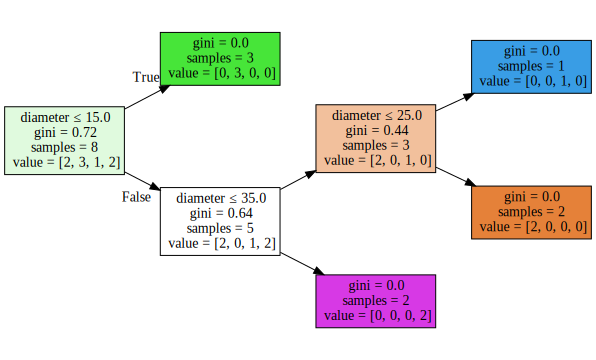

In [11]:
# Sklearn random forest for comparison
sklearn_rf = RandomForestClassifier(n_estimators=1, max_depth=3, max_features=None, min_samples_leaf= 1, bootstrap=False)
sklearn_rf.fit(x_train, y_train)
draw_tree(sklearn_rf.estimators_[0], x_train, precision=2)

#### Prediction for 1 sample

In [12]:
# Make example prediction with this model:
cols = ['color', 'diameter']
preds = my_rf.trees[0].predict(x_val_sample[cols].values)
preds

array([2])

In [13]:
# Make example prediction with sklearn model:
sklearn_rf.predict(x_val_sample)

array([2])

### Compare model with >1 trees with sklearn model
 They are expected to be different since randomness is different for 2 approaches.
 - sklearn model uses all samples with bootstrapping
 - The model built here uses subsampling to create randomness. (Easy to add bootstrapping if needed)

In [14]:
# This random forest
my_rf = Random_forest(x_train, y_train, num_trees=2, sample_size = 8, min_leaf_samples=1, max_depth = 3)
my_rf.trees[0].print_tree()
my_rf.trees[1].print_tree()

depth:0; num_samples: 8; pred_value:1; split_feature:diameter ; split_value:10; score:0.71875; 
	depth:1; num_samples: 3; pred_value:1; score:0.0; 
	depth:1; num_samples: 5; pred_value:3; split_feature:diameter ; split_value:30; score:0.6399999999999999; 
		depth:2; num_samples: 3; pred_value:0; split_feature:diameter ; split_value:20; score:0.4444444444444445; 
			depth:3; num_samples: 1; pred_value:2; score:0.0; 
			depth:3; num_samples: 2; pred_value:0; score:0.0; 
		depth:2; num_samples: 2; pred_value:3; score:0.0; 
depth:0; num_samples: 8; pred_value:1; split_feature:diameter ; split_value:10; score:0.71875; 
	depth:1; num_samples: 3; pred_value:1; score:0.0; 
	depth:1; num_samples: 5; pred_value:3; split_feature:diameter ; split_value:30; score:0.6399999999999999; 
		depth:2; num_samples: 3; pred_value:0; split_feature:diameter ; split_value:20; score:0.4444444444444445; 
			depth:3; num_samples: 1; pred_value:2; score:0.0; 
			depth:3; num_samples: 2; pred_value:0; score:0.0; 
	

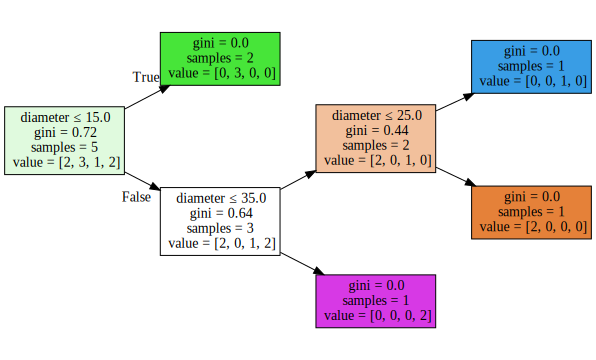

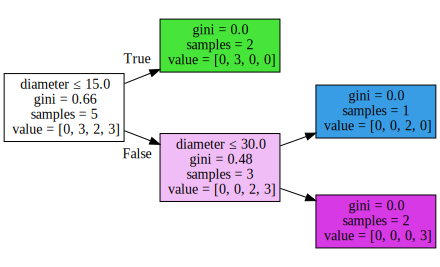

In [15]:
# Sklearn random forest for comparison
sklearn_rf = RandomForestClassifier(n_estimators=2, max_depth=3, max_features=None, min_samples_leaf= 1, bootstrap=True)
sklearn_rf.fit(x_train, y_train)
draw_tree(sklearn_rf.estimators_[0], x_train, precision=2)
draw_tree(sklearn_rf.estimators_[1], x_train, precision=2)

#### Prediction for 1 validation sample, and validation set

In [16]:
# Make example prediction with this model:
cols = ['color', 'diameter']
preds = my_rf.predict(x_val_sample[cols].values)
preds

array([2])

In [17]:
# Make example prediction with sklearn model:
sklearn_rf.predict(x_val_sample)

array([2])

In [18]:
# Make validation set prediction with this model:
preds = my_rf.predict(x_val[cols].values)
#for i in preds: print(i)
#np.array([majority_vote(np.array(preds)[:,i]) for i in range(len(x_val[cols].values))])
print(preds)
r2_score(preds, y_val)

[2 1]


-39.0

In [19]:
# Make validation set prediction with sklearn model:
preds = sklearn_rf.predict(x_val[cols].values)
print(preds)
r2_score(preds, y_val)

[2 1]


-39.0